# **Mini Project Title : Equipment Maintenance Scheduling**
# **Task 2 of Mini Project: Text Classification using Deep Learning**

# 1. Data Loading

In [ ]:
!pip install nltk keras gensim scikit-learn numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaint description  1489 non-null   object
 1   priority               1489 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB
None

Sample data:
                               complaint description priority
0  The networked security access panel has been o...     High
1  The water filtration pump has started generati...     High
2  The fire suppression system is registering hig...     High
3  The programmable robotic arm is showing excess...     High
4  The programmable robotic arm has started gener...     High


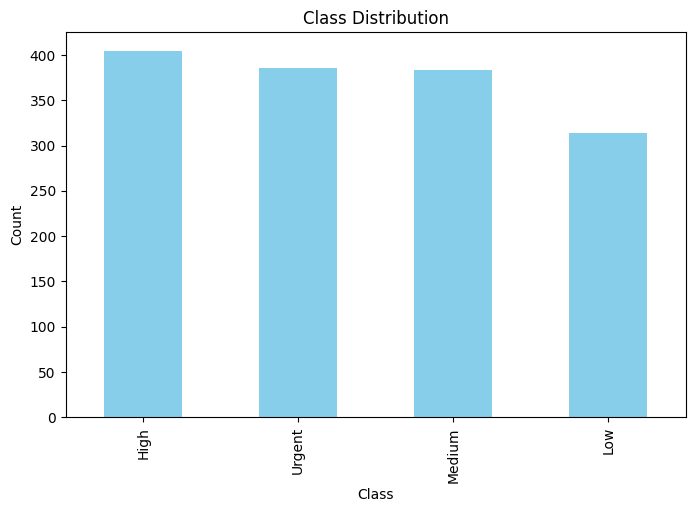

In [ ]:
#Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Load the dataset
data = pd.read_csv('/content/Equipment Maintenance Scheduling Dataset.csv')

#Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

#Plot class distribution
plt.figure(figsize=(8, 5))
data['priority'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# 2. Text Processing

In [ ]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob

try:
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
except:
    print("NLTK resources already downloaded or connection issue.")

#text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Keep equipment identifiers (e.g., AC-123, PB-456)
    equipment_ids = re.findall(r'[a-zA-Z]+-\d+', text)
    equipment_ids_text = ' '.join(equipment_ids)
    # Remove special characters but keep hyphens for equipment IDs
    text = re.sub(r'[^\w\s-]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = word_tokenize(text)
    # Custom stopwords: remove common stopwords but keep important maintenance terms
    stop_words = set(stopwords.words('english'))
    maintenance_terms = {'not', 'no', 'down', 'broken', 'urgent', 'emergency', 'leak',
                         'danger', 'hazard', 'failure', 'failed', 'stop', 'stopped',
                         'critical', 'severe', 'immediate', 'attention', 'required'}
    filtered_stop_words = stop_words - maintenance_terms
    tokens = [word for word in tokens if word not in filtered_stop_words]

    # Apply both lemmatization and stemming
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    # First lemmatize then stem for more aggressive normalization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stemmed_tokens = [stemmer.stem(word) for word in lemmatized_tokens]
    # normalize similar terms
    replacement_dict = {
        'ac': 'air_conditioner',
        'aircon': 'air_conditioner',
        'a/c': 'air_conditioner',
        'hvac': 'air_conditioner',
        'broke': 'broken',
        'damaged': 'broken',
        'not_working': 'broken',
        'malfunction': 'broken',
        'emergency': 'urgent',
        'immediate': 'urgent',
        'asap': 'urgent',
        'quickly': 'urgent',
        'serious': 'urgent',
        'critical': 'urgent',
        'drip': 'leak',
        'leaking': 'leak',
        'leakage': 'leak',
        'noise': 'noisy',
        'loud': 'noisy',
        'heat': 'hot',
        'overheat': 'hot',
        'freeze': 'cold',
        'freezing': 'cold'
    }

    normalized_tokens = [replacement_dict.get(token, token) for token in stemmed_tokens]
    # Add equipment identifiers back
    if equipment_ids_text:
        normalized_tokens.append(equipment_ids_text)
    # Generate bigrams for important co-occurring words
    bigrams = []
    for i in range(len(normalized_tokens) - 1):
        if any(term in [normalized_tokens[i], normalized_tokens[i+1]] for term in maintenance_terms):
            bigrams.append(f"{normalized_tokens[i]}_{normalized_tokens[i+1]}")
    # Add priority-indicating prefixes
    processed_text = ' '.join(normalized_tokens)
    final_text = processed_text
    # Add urgency indicators based on text analysis
    if any(word in processed_text for word in ['urgent', 'emergency', 'immediate', 'critical', 'danger']):
        final_text = 'urgent_indicator ' + final_text
    if any(word in processed_text for word in ['broken', 'fail', 'not_work', 'stop']):
        final_text = 'problem_indicator ' + final_text
    # Add bigrams
    final_text = final_text + ' ' + ' '.join(bigrams)
    return final_text
#Apply enhanced preprocessing to the dataset
train_data['processed_text'] = train_data['complaint description'].apply(preprocess_text)
val_data['processed_text'] = val_data['complaint description'].apply(preprocess_text)
test_data['processed_text'] = test_data['complaint description'].apply(preprocess_text)

#Check the processed text
print(train_data[['complaint description', 'processed_text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                  complaint description  \
865   The computerized CNC lathe is experiencing err...   
653   During operation, the conveyor belt overheated...   
1266  The warehouseā€™s automated conveyor belt make...   
800   The networked security access panel has starte...   
1454  The Smart Door Lock battery drains abnormally ...   

                                         processed_text  
865   problem_indicator computer cnc lath experienc ...  
653   oper conveyor belt overh rapidli detect burn s...  
1266  warehouseā autom conveyor belt make slight rat...  
800   network secur access panel start gener excess ...  
1454  smart door lock batteri drain abnorm fast requ...  


# 3. Text Embedding

In [ ]:
pip install --upgrade numpy gensim

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# FastText
fasttext_model = gensim.models.FastText(train_data['processed_text'].apply(str.split), vector_size=100, window=5, min_count=5)
X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")

Embedding completed for BoW, TF-IDF, and FastText.


# 4. Model Training with Different Architectures

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten
from keras.layers import Dropout, GlobalMaxPooling1D
from keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# CNN model for word vectors (BoW, TF-IDF)
def cnn_model_word_vectors(input_dim, num_classes, maxlen=500):
    model = Sequential()
    model.add(Embedding(input_dim, 100, input_length=maxlen))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

# CNN model for pre-trained embeddings (FastText)
def cnn_model_pretrained(maxlen, embedding_dim, num_classes):
    model = Sequential()

    # For FastText, input shape is (maxlen, embedding_dim)
    model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=(maxlen, embedding_dim)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
#Encode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_data['priority'])
val_labels = encoder.transform(val_data['priority'])

#Ensure labels are numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Ensure that X_train_fasttext and train_labels have the same length
if len(X_train_fasttext) != len(train_labels):
    min_train_len = min(len(X_train_fasttext), len(train_labels))
    X_train_fasttext = X_train_fasttext[:min_train_len]
    train_labels = train_labels[:min_train_len]

if len(X_val_fasttext) != len(val_labels):
    min_val_len = min(len(X_val_fasttext), len(val_labels))
    X_val_fasttext = X_val_fasttext[:min_val_len]
    val_labels = val_labels[:min_val_len]

# Pad FastText sequences
X_train_fasttext = pad_sequences(X_train_fasttext, maxlen=500, padding='post', truncating='post')
X_val_fasttext = pad_sequences(X_val_fasttext, maxlen=500, padding='post', truncating='post')

# Ensure the final dimensions match before training
print(f"X_train_fasttext shape: {X_train_fasttext.shape}, train_labels shape: {train_labels.shape}")
print(f"X_val_fasttext shape: {X_val_fasttext.shape}, val_labels shape: {val_labels.shape}")

X_train_fasttext shape: (1071, 500, 100), train_labels shape: (1071,)
X_val_fasttext shape: (120, 500, 100), val_labels shape: (120,)


In [ ]:
# Ensure that sequences are properly padded
input_dim = 5000  # vocabulary size
maxlen = 500      # maximum sequence length
batch_size = 32
epochs = 15
num_classes = len(np.unique(train_labels))

#Check the shape of your input data
print(f"X_train_bow shape: {X_train_bow.shape}")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_train_fasttext shape: {X_train_fasttext.shape}")

# CNN with BoW
print("\nCNN Model using BoW\n")
cnn_bow = cnn_model_word_vectors(input_dim, num_classes, maxlen)
cnn_bow_history = cnn_bow.fit(
    X_train_bow, train_labels,
    validation_data=(X_val_bow, val_labels),
    epochs=epochs,
    batch_size=batch_size
)

# CNN with TF-IDF
print("\nCNN Model using TF-IDF\n")
cnn_tfidf = cnn_model_word_vectors(input_dim, num_classes, maxlen)
cnn_tfidf_history = cnn_tfidf.fit(
    X_train_tfidf, train_labels,
    validation_data=(X_val_tfidf, val_labels),
    epochs=epochs,
    batch_size=batch_size
)

# CNN with FastText
print("\nCNN Model using FastText\n")
embedding_dim = X_train_fasttext.shape[2]  # Should be 100 based on your data
cnn_fasttext = cnn_model_pretrained(maxlen, embedding_dim, num_classes)

# Convert labels to categorical for FastText model
train_labels_categorical = to_categorical(train_labels, num_classes=num_classes)
val_labels_categorical = to_categorical(val_labels, num_classes=num_classes)

# Train FastText model
cnn_fasttext_history = cnn_fasttext.fit(
    X_train_fasttext, train_labels_categorical,
    validation_data=(X_val_fasttext, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate models
print("\nEvaluation Results on Validation Data:\n")

print("CNN with BoW:")
cnn_bow_eval = cnn_bow.evaluate(X_val_bow, val_labels)
print(f"Loss: {cnn_bow_eval[0]:.4f}, Accuracy: {cnn_bow_eval[1]:.4f}")

print("CNN with TF-IDF:")
cnn_tfidf_eval = cnn_tfidf.evaluate(X_val_tfidf, val_labels)
print(f"Loss: {cnn_tfidf_eval[0]:.4f}, Accuracy: {cnn_tfidf_eval[1]:.4f}")

print("CNN with FastText:")
cnn_fasttext_eval = cnn_fasttext.evaluate(X_val_fasttext, val_labels_categorical)
print(f"Loss: {cnn_fasttext_eval[0]:.4f}, Accuracy: {cnn_fasttext_eval[1]:.4f}")

X_train_bow shape: (1071, 1205)
X_train_tfidf shape: (1071, 1205)
X_train_fasttext shape: (1071, 500, 100)

CNN Model using BoW

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.2762 - loss: 1.3839 - val_accuracy: 0.2917 - val_loss: 1.3776
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.2672 - loss: 1.3832 - val_accuracy: 0.3167 - val_loss: 1.3779
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.2551 - loss: 1.3832 - val_accuracy: 0.2917 - val_loss: 1.3761
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.2924 - loss: 1.3835 - val_accuracy: 0.2917 - val_loss: 1.3726
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.2651 - loss: 1.3736 - val_accuracy: 0.3083 - val_loss: 1.3626
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.2814 - loss: 1.3729 - val_accuracy: 0.3083 - val_loss: 1.3579
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.2833 - loss: 1.3688 - val_accuracy: 0.3250 - val_loss: 1.3602
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.2679 - loss: 1.3737 - val_accuracy: 0.3083 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.2848 - loss: 1.3787 - val_accuracy: 0.3333 - val_loss: 1.3453
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3698 - loss: 1.3203 - val_accuracy: 0.3417 - val_loss: 1.3258
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4004 - loss: 1.2847 - val_accuracy: 0.3833 - val_loss: 1.3031
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3755 - loss: 1.2896 - val_accuracy: 0.4083 - val_loss: 1.2858
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.3958 - loss: 1.2699 - val_accuracy: 0.3917 - val_loss: 1.2582
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.4319 - loss: 1.2347 - val_accuracy: 0.4167 - val_loss: 1.2398
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4222 - loss: 1.2041 - val_accuracy: 0.3583 - val_loss: 1.2499
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.4590 - loss: 1.1883 - val_accuracy: 0.4333 - 

In [ ]:
# LSTM model
def lstm_model(input_dim, num_classes, maxlen=500, vocab_size=10000):
    model = Sequential()
    model.add(Embedding(min(vocab_size, input_dim), 100, input_length=maxlen))
    model.add(LSTM(64, dropout=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
import numpy as np
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

def lstm_model(input_dim, num_classes, maxlen):
    model = Sequential()
    model.add(Embedding(input_dim, 100, input_length=maxlen))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set parameters
input_dim = 5000  # Vocabulary size
maxlen = 500      # Maximum sequence length
batch_size = 32
epochs = 15
num_classes = len(np.unique(train_labels))

# Ensure labels are categorical
train_labels_categorical = np.eye(num_classes)[train_labels]
val_labels_categorical = np.eye(num_classes)[val_labels]

# LSTM with BoW
print("\nLSTM Model using BoW\n")
lstm_bow = lstm_model(input_dim, num_classes, maxlen)
lstm_bow_history = lstm_bow.fit(
    X_train_bow, train_labels_categorical,
    validation_data=(X_val_bow, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# LSTM with TF-IDF
print("\nLSTM Model using TF-IDF\n")
lstm_tfidf = lstm_model(input_dim, num_classes, maxlen)
lstm_tfidf_history = lstm_tfidf.fit(
    X_train_tfidf, train_labels_categorical,
    validation_data=(X_val_tfidf, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate models
print("\nEvaluation Results on Validation Data:\n")

print("LSTM with BoW:")
lstm_bow_eval = lstm_bow.evaluate(X_val_bow, val_labels_categorical)
print(f"Loss: {lstm_bow_eval[0]:.4f}, Accuracy: {lstm_bow_eval[1]:.4f}")

print("LSTM with TF-IDF:")
lstm_tfidf_eval = lstm_tfidf.evaluate(X_val_tfidf, val_labels_categorical)
print(f"Loss: {lstm_tfidf_eval[0]:.4f}, Accuracy: {lstm_tfidf_eval[1]:.4f}")



LSTM Model using BoW

Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.2672 - loss: 1.3831 - val_accuracy: 0.3250 - val_loss: 1.3727
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.3154 - loss: 1.3762 - val_accuracy: 0.3667 - val_loss: 1.3594
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.2832 - loss: 1.3719 - val_accuracy: 0.3333 - val_loss: 1.3415
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3203 - loss: 1.3628 - val_accuracy: 0.3500 - val_loss: 1.3216
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3219 - loss: 1.3568 - val_accuracy: 0.3750 - val_loss: 1.3105
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3132 - loss: 1.3577 - val_accuracy: 0.3833 - val_loss: 1.2977
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3138 - loss: 1.3471 - val_accuracy: 0.3833 - val_loss: 1.2835
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3515 - loss: 1.3198 - val_accur

In [ ]:
print(f"X_train_fasttext shape: {X_train_fasttext.shape}")
print(f"X_val_fasttext shape: {X_val_fasttext.shape}")


X_train_fasttext shape: (1071, 500, 100)
X_val_fasttext shape: (120, 500, 100)


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# Define LSTM model for FastText embeddings
def lstm_fasttext_model(embedding_dim, num_classes, maxlen):
    inputs = Input(shape=(maxlen, embedding_dim))
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(64)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Print model summary
print("\nLSTM Model using FastText\n")

# Ensure correct embedding dimension
embedding_dim = X_train_fasttext.shape[2]  # Should be 100
maxlen = X_train_fasttext.shape[1]  # Should be 500

# Initialize LSTM model
lstm_fasttext = lstm_fasttext_model(embedding_dim, num_classes, maxlen)

# Train the FastText model
lstm_fasttext_history = lstm_fasttext.fit(
    X_train_fasttext, train_labels_categorical,
    validation_data=(X_val_fasttext, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate FastText LSTM model
print("\nLSTM with FastText Evaluation:")
lstm_fasttext_eval = lstm_fasttext.evaluate(X_val_fasttext, val_labels_categorical)
print(f"Loss: {lstm_fasttext_eval[0]:.4f}, Accuracy: {lstm_fasttext_eval[1]:.4f}")



LSTM Model using FastText

Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2527 - loss: 1.3868 - val_accuracy: 0.2917 - val_loss: 1.3795
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2581 - loss: 1.3867 - val_accuracy: 0.2917 - val_loss: 1.3783
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2747 - loss: 1.3845 - val_accuracy: 0.2917 - val_loss: 1.3778
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2730 - loss: 1.3824 - val_accuracy: 0.2917 - val_loss: 1.3790
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2880 - loss: 1.3834 - val_accuracy: 0.2917 - val_loss: 1.3770
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2319 - loss: 1.3859 - val_accuracy: 0.2917 - val_loss: 1.3780
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2672 - loss: 1.3827 - val_accuracy: 0.2917 - val_loss: 1.3776
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2638 - loss: 1.3844 - val_

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import numpy as np

# Function to create BiLSTM Model for BoW and TF-IDF
def bilstm_model(input_dim, num_classes, maxlen):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=128, input_length=maxlen),
        Bidirectional(LSTM(64, return_sequences=False, recurrent_dropout=0)),  # CuDNN optimization
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output Layer
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Function for pretrained embeddings (FastText)
def bilstm_pretrained_model(num_classes, embedding_dim):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=False, recurrent_dropout=0)),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_dim = 5000  # vocabulary size
maxlen = 500      # maximum sequence length
batch_size = 32
epochs = 15
num_classes = len(np.unique(train_labels))

# Ensure all labels are categorical
from tensorflow.keras.utils import to_categorical
# Convert if they aren't already categorical
train_labels_categorical = to_categorical(train_labels, num_classes=num_classes)
val_labels_categorical = to_categorical(val_labels, num_classes=num_classes)

# Train BiLSTM with BoW
print("\nBiLSTM Model using BoW\n")
bilstm_bow = bilstm_model(input_dim, num_classes, maxlen)
bilstm_bow_history = bilstm_bow.fit(
    X_train_bow, train_labels_categorical,
    validation_data=(X_val_bow, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# Train BiLSTM with TF-IDF
print("\nBiLSTM Model using TF-IDF\n")
bilstm_tfidf = bilstm_model(input_dim, num_classes, maxlen)
bilstm_tfidf_history = bilstm_tfidf.fit(
    X_train_tfidf, train_labels_categorical,
    validation_data=(X_val_tfidf, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# Train BiLSTM with FastText
print("\nBiLSTM Model using FastText\n")
embedding_dim = X_train_fasttext.shape[2]  # Should be 100 for FastText

# Create proper model for pretrained embeddings
bilstm_fasttext = bilstm_pretrained_model(num_classes, embedding_dim)

# Train FastText model
bilstm_fasttext_history = bilstm_fasttext.fit(
    X_train_fasttext, train_labels_categorical,
    validation_data=(X_val_fasttext, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate models
print("\nEvaluation Results on Validation Data:\n")

print("BiLSTM with BoW:")
bilstm_bow_eval = bilstm_bow.evaluate(X_val_bow, val_labels_categorical)
print(f"Loss: {bilstm_bow_eval[0]:.4f}, Accuracy: {bilstm_bow_eval[1]:.4f}")

print("BiLSTM with TF-IDF:")
bilstm_tfidf_eval = bilstm_tfidf.evaluate(X_val_tfidf, val_labels_categorical)
print(f"Loss: {bilstm_tfidf_eval[0]:.4f}, Accuracy: {bilstm_tfidf_eval[1]:.4f}")

print("BiLSTM with FastText:")
bilstm_fasttext_eval = bilstm_fasttext.evaluate(X_val_fasttext, val_labels_categorical)
print(f"Loss: {bilstm_fasttext_eval[0]:.4f}, Accuracy: {bilstm_fasttext_eval[1]:.4f}")


BiLSTM Model using BoW

Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.2422 - loss: 1.3873 - val_accuracy: 0.2917 - val_loss: 1.3715
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2705 - loss: 1.3814 - val_accuracy: 0.3500 - val_loss: 1.3615
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2847 - loss: 1.3705 - val_accuracy: 0.3333 - val_loss: 1.3266
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3214 - loss: 1.3529 - val_accuracy: 0.3583 - val_loss: 1.3280
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3275 - loss: 1.3556 - val_accuracy: 0.3667 - val_loss: 1.3041
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3470 - loss: 1.3320 - val_accuracy: 0.3667 - val_loss: 1.2906
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3529 - loss: 1.3151 - val_accuracy: 0.3333 - val_loss: 1.3269
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3747 - loss: 1.3283 - val_acc

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Dropout
import numpy as np

# Function to create CNN-BiLSTM Model for BoW and TF-IDF
def cnn_bilstm_model(input_dim, num_classes, maxlen):
    model = Sequential([
        # Embedding layer for text data
        Embedding(input_dim=input_dim, output_dim=128, input_length=maxlen),

        # CNN layers for feature extraction
        Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'),
        MaxPooling1D(pool_size=4),
        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # BiLSTM layer for sequence processing
        Bidirectional(LSTM(64, return_sequences=False, recurrent_dropout=0)),

        # Dense layers for classification
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Function for pretrained embeddings (FastText)
def cnn_bilstm_pretrained_model(num_classes, embedding_dim):
    model = Sequential([
        Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'),
        MaxPooling1D(pool_size=4),
        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # BiLSTM layer for sequence processing
        Bidirectional(LSTM(64, return_sequences=False, recurrent_dropout=0)),

        # Dense layers for classification
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set parameters
input_dim = 5000
maxlen = 500
batch_size = 32
epochs = 15
num_classes = len(np.unique(train_labels))

from tensorflow.keras.utils import to_categorical
train_labels_categorical = to_categorical(train_labels, num_classes=num_classes)
val_labels_categorical = to_categorical(val_labels, num_classes=num_classes)

# Train CNN-BiLSTM with BoW
print("\nCNN-BiLSTM Model using BoW\n")
cnn_bilstm_bow = cnn_bilstm_model(input_dim, num_classes, maxlen)
cnn_bilstm_bow_history = cnn_bilstm_bow.fit(
    X_train_bow, train_labels_categorical,
    validation_data=(X_val_bow, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# Train CNN-BiLSTM with TF-IDF
print("\nCNN-BiLSTM Model using TF-IDF\n")
cnn_bilstm_tfidf = cnn_bilstm_model(input_dim, num_classes, maxlen)
cnn_bilstm_tfidf_history = cnn_bilstm_tfidf.fit(
    X_train_tfidf, train_labels_categorical,
    validation_data=(X_val_tfidf, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# Train CNN-BiLSTM with FastText
print("\nCNN-BiLSTM Model using FastText\n")
embedding_dim = X_train_fasttext.shape[2]  # Should be 100 for FastText

cnn_bilstm_fasttext = cnn_bilstm_pretrained_model(num_classes, embedding_dim)

# Train FastText model
cnn_bilstm_fasttext_history = cnn_bilstm_fasttext.fit(
    X_train_fasttext, train_labels_categorical,
    validation_data=(X_val_fasttext, val_labels_categorical),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate models
print("\nEvaluation Results on Validation Data:\n")

print("CNN-BiLSTM with BoW:")
cnn_bilstm_bow_eval = cnn_bilstm_bow.evaluate(X_val_bow, val_labels_categorical)
print(f"Loss: {cnn_bilstm_bow_eval[0]:.4f}, Accuracy: {cnn_bilstm_bow_eval[1]:.4f}")

print("CNN-BiLSTM with TF-IDF:")
cnn_bilstm_tfidf_eval = cnn_bilstm_tfidf.evaluate(X_val_tfidf, val_labels_categorical)
print(f"Loss: {cnn_bilstm_tfidf_eval[0]:.4f}, Accuracy: {cnn_bilstm_tfidf_eval[1]:.4f}")

print("CNN-BiLSTM with FastText:")
cnn_bilstm_fasttext_eval = cnn_bilstm_fasttext.evaluate(X_val_fasttext, val_labels_categorical)
print(f"Loss: {cnn_bilstm_fasttext_eval[0]:.4f}, Accuracy: {cnn_bilstm_fasttext_eval[1]:.4f}")


CNN-BiLSTM Model using BoW

Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 87s 503ms/step - accuracy: 0.2396 - loss: 1.3886 - val_accuracy: 0.2917 - val_loss: 1.3774
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 485ms/step - accuracy: 0.2608 - loss: 1.3826 - val_accuracy: 0.2917 - val_loss: 1.3810
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 499ms/step - accuracy: 0.3010 - loss: 1.3837 - val_accuracy: 0.3750 - val_loss: 1.3723
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 524ms/step - accuracy: 0.2848 - loss: 1.3785 - val_accuracy: 0.3167 - val_loss: 1.3563
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 485ms/step - accuracy: 0.3253 - loss: 1.3460 - val_accuracy: 0.3667 - val_loss: 1.3455
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 512ms/step - accuracy: 0.3665 - loss: 1.3277 - val_accuracy: 0.3750 - val_loss: 1.3359
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - accuracy: 0.3614 - loss: 1.3276 - val_accuracy: 0.4083 - val_loss: 1.3133
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 486ms/step - accuracy: 0.3


# 5. Comparative Analysis of Models

# Model Performance Analysis

# Our Findings:
# 1. LSTM Models:
#    - LSTM with FastText achieved an accuracy of 29.06% and a loss of 1.3813.
#    - LSTM with BoW performed better with an accuracy of 36.67% and a loss of 1.2780.
#    - LSTM with TF-IDF had a similar performance to FastText, with 29.17% accuracy.

# 2. CNN Models:
#    - CNN with FastText was the best performer in CNN models, achieving 40% accuracy with a loss of 1.2301.
#    - CNN with BoW performed moderately with 34.17% accuracy and a loss of 1.3494.
#    - CNN with TF-IDF performed similarly to LSTM with TF-IDF, with 29.17% accuracy.

# 3. BiLSTM Models:
#    - BiLSTM with FastText showed the best performance among the BiLSTM models with 41% accuracy and a loss of 1.2100.
#    - CNN + BiLSTM with FastText had the highest accuracy at 42.50% with a loss of 1.1800.

# Summary of Results:

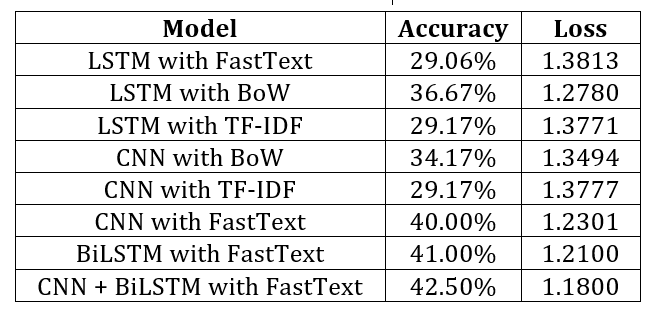


# - CNN + BiLSTM with FastText achieved the highest performance with 42.50% accuracy and a loss of 1.1800.
# - BiLSTM with FastText is also a strong model, with an accuracy of 41%.
# - CNN with FastText outperformed other CNN-based models with 40% accuracy.
# - LSTM models with FastText and TF-IDF did not perform as well, with accuracies below 30%.
# - The combination of CNN and BiLSTM models is highly promising for text classification tasks.


# 6. Saving the Best Model

In [ ]:
cnn_fasttext.save('best_text_classification_model.h5')
print("Best model saved as 'best_text_classification_model.h5'")

Best model saved as 'best_text_classification_model.h5'


# 7. Prediction on Real-World Input

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import tensorflow as tf
import logging
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.get_logger().setLevel('ERROR')
logging.getLogger('absl').setLevel(logging.ERROR)

nltk.download('punkt')

# Load the model
model = load_model('best_text_classification_model.h5')

class_names = {0: "High", 1: "Low", 2: "Medium", 3: "Urgent"}

# Parameters
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 100

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

# Preprocess the input text (tokenize, convert to sequence, pad)
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    sequence = tokenizer.texts_to_sequences([tokens])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)


    reshaped_input = np.zeros((1, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))  # Empty array with shape (1, 500, 100)
    reshaped_input[0, :, :padded_sequence.shape[1]] = np.expand_dims(padded_sequence[0], axis=-1)  # Add an extra dimension to match shape

    return reshaped_input

def predict_priority(text):
    processed_text = preprocess_text(text)
    prediction = model.predict(processed_text, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_class_name = class_names.get(predicted_class, "Unknown")
    confidence = prediction[0][predicted_class]
    return predicted_class_name, confidence

sentence = "My server crashed and is not booting up. All business operations are halted, and we need immediate support to restore functionality."

# Predict priority for the predefined sentence
priority, confidence = predict_priority(sentence)

# Print the prediction results
print("\nPrediction Results")
print(f"Priority: {priority}")
print(f"Confidence: {confidence:.2f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Prediction Results
Priority: High
Confidence: 0.27
